In [12]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
#from prophet import Prophet

In [13]:
# Load the data from a CSV file
df = pd.read_csv("../data/pollofpolls.csv", sep=";")

In [14]:
#df

In [15]:
# Ensure the "Mnd" column is treated as a string (optional but recommended)
df["Mnd"] = df["Mnd"].astype(str)

# Create an empty dictionary for the predictions
predictions = {"Mnd": ["Februar-25", "Mars-25","April-25","Mai-25","Juni-25","Juli-25","August-25","September-25"]}


In [16]:
month_mapping = {
    "Januar": "January", "Februar": "February", "Mars": "March", "April": "April",
    "Mai": "May", "Juni": "June", "Juli": "July", "August": "August",
    "September": "September", "Oktober": "October", "November": "November", "Desember": "December"
}

# Replace Norwegian months with English
df["Mnd"] = df["Mnd"].replace(month_mapping, regex=True)

# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"], format="%B-%y").dt.to_period("M").dt.to_timestamp("M")

# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

#print(df)  # Check that dates are correctly formatted at month-end


In [17]:
# Perform ADF test on each party's time series
for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG','Rodt', 'Andre']: 
    result = adfuller(df[party])
    print(f"{party} ADF Statistic: {result[0]}, p-value: {result[1]}")
    if result[1] > 0.05:
        print(f"Warning: {party} is not stationary, consider differencing.")

Ap ADF Statistic: -2.1431351909817096, p-value: 0.22752700223748779
Hoyre ADF Statistic: -1.8196635186008094, p-value: 0.37074392214204605
Frp ADF Statistic: 1.2116325044195977, p-value: 0.9960652755506311
SV ADF Statistic: -3.143500966393524, p-value: 0.023496976073433522
Sp ADF Statistic: -3.1838888208581144, p-value: 0.02093640394522018
KrF ADF Statistic: -4.707234698517839, p-value: 8.155841832630618e-05
Venstre ADF Statistic: -1.9660630228172478, p-value: 0.30164858101469527
MDG ADF Statistic: -2.585936634044432, p-value: 0.09593885432671917
Rodt ADF Statistic: -3.0468191741656767, p-value: 0.030747424499184044
Andre ADF Statistic: -1.8129280146418307, p-value: 0.3740624451383301


In [18]:
df_diff = df.diff().dropna()  # Difference to make stationary

In [2]:
model = VAR(df_diff)  # Use df_diff if differenced data is needed
#model_fitted = model.fit(45)  # Choose lag order (5 is an example, tune this)
model_fitted = model.fit(maxlags=3, ic='aic', method = 'ols', trend='n', verbose=True)

# Display the summary of the fitted model
print(model_fitted.summary())
#model_fitted.k_ar

NameError: name 'VAR' is not defined

In [3]:
steps = 8  # Number of steps to forecast
alpha = 0.05  # 95% confidence interval

forecast, lower, upper = model_fitted.forecast_interval(df_diff.values[-model_fitted.k_ar:], steps=steps, alpha=alpha)

# Convert forecasted values to DataFrames
forecast_dates = pd.date_range(start="2025-02-28", periods=steps, freq='ME')
forecast_diff_df = pd.DataFrame(forecast, index=forecast_dates, columns=df.columns)
forecast_lower_diff_df = pd.DataFrame(lower, index=forecast_dates, columns=df.columns)
forecast_upper_diff_df = pd.DataFrame(upper, index=forecast_dates, columns=df.columns)

# Convert predictions back to original scale
last_actual_value = df.iloc[-1]  # Last known actual data point

forecast_original_scale = forecast_diff_df.cumsum() + last_actual_value
forecast_lower_original_scale = forecast_lower_diff_df.cumsum() + last_actual_value
forecast_upper_original_scale = forecast_upper_diff_df.cumsum() + last_actual_value


NameError: name 'model_fitted' is not defined

<Figure size 1200x600 with 0 Axes>

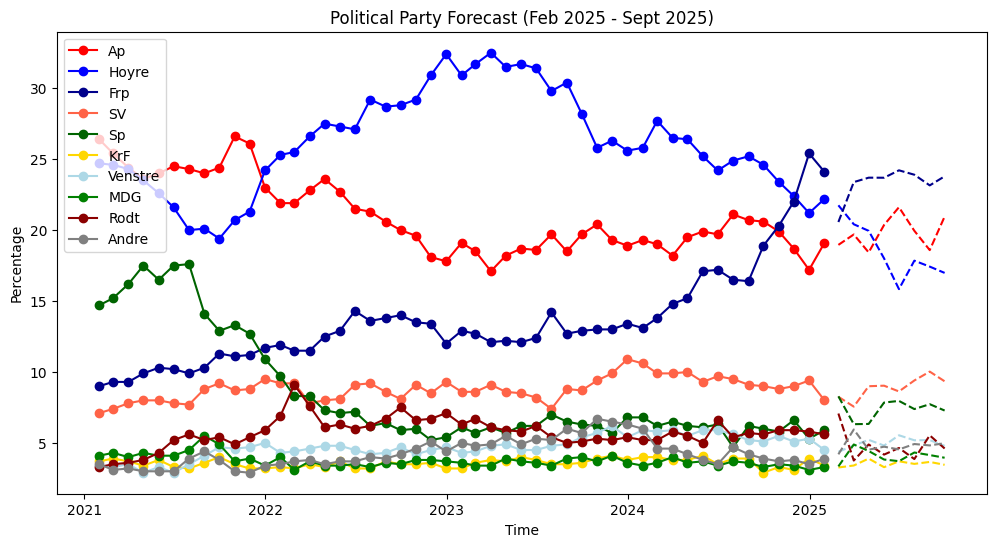

In [23]:
plt.figure(figsize=(12, 6))


# Define a color map for consistency
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
    'Frp': '#00008B',       # Dark Blue
    'SV': '#FF6347',        # Light Red (Tomato)
    'Sp': '#006400',        # Dark Green
    'KrF': '#FFD700',       # Yellow (Gold)
    'Venstre': '#ADD8E6',   # Light Blue
    'MDG': '#008000',       # Green
    'Rodt': '#8B0000',      # Dark Red
    'Andre': '#808080'      # Gray
}


plt.figure(figsize=(12, 6))

for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG','Rodt', 'Andre']:
    color = colors.get(party, np.random.rand(3,))  # Use predefined color or random if missing
    
    # Plot actual data
    plt.plot(df.index, df[party], marker="o", color=color, label=f"{party}")

    # Plot forecast with the same color
    plt.plot(forecast_original_scale.index, forecast_original_scale[party], linestyle="dashed", color=color)

plt.xlabel("Time")
plt.ylabel("Percentage")
plt.title("Political Party Forecast (Feb 2025 - Sept 2025)")
plt.legend()
plt.show()

In [24]:
forecast_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-02-28,18.957328,21.746827,20.568038,8.252145,8.284700,3.269263,4.373102,3.346777,7.071741,4.196129
2025-03-31,19.690069,20.410575,23.382197,7.557763,6.321462,3.408448,4.820042,4.890200,3.758675,5.947498
2025-04-30,18.425553,19.947328,23.694208,8.996682,6.338500,3.895978,5.217085,4.428704,4.890139,4.522832
2025-05-31,20.359912,18.006001,23.689655,9.033807,7.845514,3.290509,4.811995,3.830173,4.177349,4.734766
2025-06-30,21.612505,15.840539,24.211831,8.628539,7.960934,3.704647,5.540284,3.713588,4.643291,4.540840
2025-07-31,19.949340,17.844604,23.901417,9.400918,7.386248,3.523083,5.185790,4.324678,3.863740,4.923166
2025-08-31,18.589561,17.425311,23.149140,10.026551,7.730094,3.660455,5.200185,4.144291,5.533144,4.823604
2025-09-30,20.953591,16.982589,23.789532,9.342466,7.282583,3.457100,4.793933,3.955331,4.607709,4.979845
